## Official dataset creation for 1b

In [15]:
import os
import sys
import torch 
import pickle
import numpy as np
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

seed = 0
np.random.seed(seed)

path = '../../../gld/train-data-probes/data/1b'

In [16]:
with open(os.path.join(path, 'pile/pile_all_mem_status.pkl'), 'rb') as f:
    pile_status = pickle.load(f)

with open(os.path.join(path, 'pile/pile_all_generations.pkl'), 'rb') as f:
    pile_all_generations = pickle.load(f)

with open(os.path.join(path, 'pile/pile_all_tokens.pkl'), 'rb') as f:
    pile_all_tokens = pickle.load(f)

print('Loaded pile data')

with open(os.path.join(path, 'pythia-evals/mem_all_mem_status.pkl'), 'rb') as f:
    status = pickle.load(f)

with open(os.path.join(path, 'pythia-evals/mem_all_generations.pkl'), 'rb') as f:
    mem_all_generations = pickle.load(f)

with open(os.path.join(path, 'pythia-evals/mem_all_tokens.pkl'), 'rb') as f:
    mem_all_tokens = pickle.load(f)

print('Loaded mem data')

Loaded pile data
Loaded mem data


In [17]:
def gen_pile_data(N, tokenizer, min_n_toks : int = None):
    pile = load_dataset('EleutherAI/the_pile_deduplicated', split='train', streaming=True)
    sentences = []

    counter = 0
    for i, example in enumerate(pile):
        if min_n_toks is not None:
            toks = tokenizer(example['text'])['input_ids']
            if len(toks) > min_n_toks:
                sentences.append(example['text'])
                counter +=1
        else:
            sentences.append(example['text'])
            counter +=1
        
        if counter == N:
            break

    return sentences

N_PROMPTS = 5000
model_name = "EleutherAI/pythia-1b"
dataset_name = "duped." + model_name.split("-")[-1]
tokenizer = AutoTokenizer.from_pretrained(model_name)

mem_data = load_dataset('EleutherAI/pythia-memorized-evals')[dataset_name]
mem_data_toks = [seq for seq in mem_data[:N_PROMPTS]['tokens']]
pile_prompts = gen_pile_data(N_PROMPTS, tokenizer, min_n_toks = 64)

print(len(pile_prompts))
print(len(mem_data_toks))
    
tok_idxs =  (7 * np.arange(10)).tolist() #every 5th token
tok_idxs[-1]= tok_idxs[-1] - 1 #goes from 63 to 62
print(tok_idxs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Resolving data files: 100%|██████████| 1650/1650 [00:02<00:00, 620.35it/s]


5000
5000
[0, 7, 14, 21, 28, 35, 42, 49, 56, 62]


In [18]:
import pandas as pd

# create df

source = ['pythia-evals' for _ in range(N_PROMPTS)] + ['pile' for _ in range(N_PROMPTS)]
gen = mem_all_generations + pile_all_generations
mem_str = tokenizer.batch_decode(mem_all_tokens, skip_special_tokens=True)
ground = mem_str + pile_prompts
mem_status = status['tok_by_tok_sim'] + pile_status['tok_by_tok_sim']
char_status = status['char_by_char_sim'] + pile_status['char_by_char_sim']
lev_status = status['lev_distance'] + pile_status['lev_distance']
orig_index = [i for i in range(N_PROMPTS)] + [i for i in range(N_PROMPTS)]
toks = mem_all_tokens + pile_all_tokens

df = pd.DataFrame(list(zip(gen, ground, mem_status, char_status, lev_status, toks, source, orig_index)), 
               columns =['gen', 'ground', 'tok_by_tok_sim', 'char_by_char_sim', 'lev_distance', 'toks', 'source', 'orig_index'])

df.to_csv(os.path.join(path, 'data.csv'), index=False, escapechar='\\')

In [19]:
import pandas as pd

df = pd.read_csv(os.path.join(path, 'data.csv'), escapechar='\\')
df = df.drop_duplicates(subset=['gen', 'ground'], keep='first')
len(df)

9853

### Data cleaning

In [20]:
# remove common patterns
from collections import Counter

def has_repeated_majority(arr, frac = 1/2):
    """
    Check if any value in the array is repeated more than half the length of the array.

    Parameters:
    arr (list): The input list of numbers.

    Returns:
    bool: True if a majority element exists, False otherwise.
    """
    if not arr:
        return False

    count = Counter(arr)
    length = len(arr)

    for key, value in count.items():
        if value > length * frac:
            return True

    return False

df['toks'] = df['toks'].apply(lambda x: eval(x))
rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if has_repeated_majority(row['toks'], frac=1/4):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

9853it [00:00, 19381.88it/s]

281


In [21]:
import re

def remove_punc(string):
    return re.sub(r'[\[\]._,\-]', '', string)

def remove_non_numeric(string):
    return re.sub(r'[^\d]', '', string)

def check_repeated_string(string):
    # Remove periods, underscores, dashes, and other special characters
    string = remove_punc(string)
    words = string.split()
    if len(words) == 0:
        return False
    else:
        return all(words[i] == words[i+1] for i in range(len(words)-1))
    
def check_increment(string):
    # Remove periods, underscores, dashes, and other special characters
    numbers = [int(remove_punc(word.strip())) for word in string.split() if remove_punc(word.strip()).isdigit()]
    if len(numbers) < 4:
        return False
    else:
        all_inc = all(numbers[i] == numbers[i+1] - 1 for i in range(len(numbers)-1)) 
        all_dec = all(numbers[i] ==  numbers[i+1] + 1 for i in range(len(numbers)-1))
        return all_inc or all_dec 
    
rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if check_repeated_string(row['gen']) or check_increment(row['gen']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

9572it [00:00, 11258.51it/s]

155


In [22]:
def repeats_subseq(toks, n=10): 
    """
    Returns True if has a tok seq contains a subsequence of length n that is repeated more than once. 
    """
    for i in range(len(toks) - n):
        subseq = toks[i:i+n]
        for j in range(i+1, len(toks) - n):
            if toks[j:j+n] == subseq:
                return True
    return False

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if repeats_subseq(row['toks']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

9417it [00:02, 4564.48it/s]

1870


### Checking memorization scores

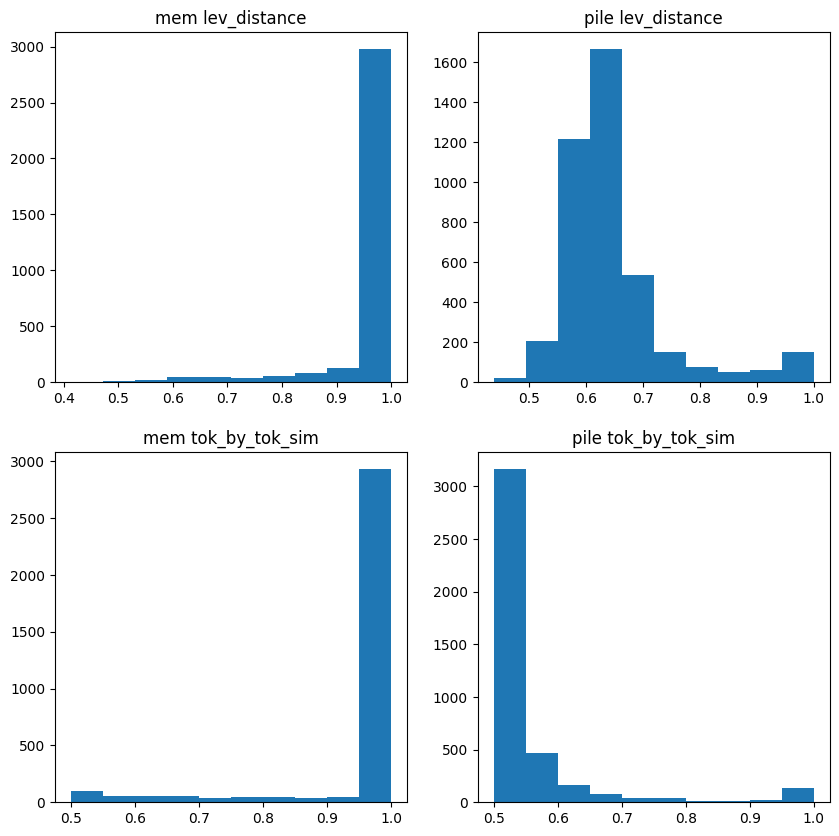

In [23]:
import matplotlib.pyplot as plt

pile_df = df[df['source'] == 'pile']
mem_df = df[df['source'] == 'pythia-evals']

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].hist(mem_df['lev_distance'])
ax[0,1].hist(pile_df['lev_distance'])
ax[1,0].hist(mem_df['tok_by_tok_sim'])
ax[1,1].hist(pile_df['tok_by_tok_sim'])
ax[0,0].set_title('mem lev_distance')
ax[0,1].set_title('pile lev_distance')
ax[1,0].set_title('mem tok_by_tok_sim')
ax[1,1].set_title('pile tok_by_tok_sim')
plt.show()

### Make train splits

In [24]:
neg = df[df['tok_by_tok_sim'] <= 0.55]
pos = df[df['tok_by_tok_sim'] == 1]

print(len(neg), len(pos))

min_len = min(len(neg), len(pos))

positive_idxs = pos.index.tolist()
negative_idxs = neg.index.tolist()

# sample 
import numpy as np
np.random.seed(0)
positive_idxs = np.random.choice(positive_idxs, min_len, replace=False)
negative_idxs = np.random.choice(negative_idxs, min_len, replace=False)

3262 2923


In [25]:
final_tokens = []
final_str = []
labels = []
for i in tqdm(positive_idxs): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)
for i in tqdm(negative_idxs):
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(0)

print(len(final_tokens), len(final_str), len(labels), len(df))
print(sum(labels)/len(labels))

100%|██████████| 2923/2923 [00:00<00:00, 68967.96it/s]

5846 5846 5846 7547
0.5


In [26]:
from datasets import Dataset, DatasetDict, load_from_disk
idxs = positive_idxs.tolist() + negative_idxs.tolist()
dataset = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': idxs})
print(len(dataset))

dataset = dataset.shuffle(seed=seed)
dataset = dataset.train_test_split(test_size=0.3)
test = dataset['test']
temp = dataset['train'].train_test_split(test_size=1/7)
train = temp['train']
val = temp['test']
dataset = DatasetDict({'train': train, 'val': val, 'test': test})

input_ids = {'train': [], 'val': [], 'test': []}
texts = {'train': [], 'val': [], 'test': []}
labels = {'train': [], 'val': [], 'test': []}
orig_idx = {'train': [], 'val': [], 'test': []}
cutoff_at = {'train': [], 'val': [], 'test': []}
for cutoff in tok_idxs[5:]: 
    print(cutoff)
    for split in ['train', 'val', 'test']:
        input_ids[split].extend([x[:cutoff] for x in dataset[split]['input_ids']])
        texts[split].extend(dataset[split]['text'])
        labels[split].extend(dataset[split]['labels'])
        orig_idx[split].extend(dataset[split]['orig_idx'])
        cutoff_at[split].extend([cutoff for _ in range(len(dataset[split]['input_ids']))])

dataset = DatasetDict({'train': Dataset.from_dict({'input_ids': input_ids['train'], 'text': texts['train'], 'labels': labels['train'], 'orig_idx': orig_idx['train'], 'cutoff_at': cutoff_at['train']}),
                          'val': Dataset.from_dict({'input_ids': input_ids['val'], 'text': texts['val'], 'labels': labels['val'], 'orig_idx': orig_idx['val'], 'cutoff_at': cutoff_at['val']}),
                          'test': Dataset.from_dict({'input_ids': input_ids['test'], 'text': texts['test'], 'labels': labels['test'], 'orig_idx': orig_idx['test'], 'cutoff_at': cutoff_at['test']})})

5846
35


42
49
56
62


In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx', 'cutoff_at'],
        num_rows: 17535
    })
    val: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx', 'cutoff_at'],
        num_rows: 2925
    })
    test: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx', 'cutoff_at'],
        num_rows: 8770
    })
})

In [28]:
dataset.save_to_disk(os.path.join(path, 'split_dataset'))

Saving the dataset (0/1 shards):   0%|          | 0/17535 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 8770/8770 [00:00<00:00, 192412.35 examples/s]


### Make generalization datasets

In [29]:
hard_pos = df[df['tok_by_tok_sim'] != 1]
hard_pos = hard_pos[hard_pos['tok_by_tok_sim'] >= 0.9]
                    
positive_idxs = hard_pos.index.tolist()

print(len(hard_pos))

205


In [30]:
final_tokens = []
final_str = []
labels = []
for i in hard_pos.index.tolist(): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)

print(len(final_tokens), len(final_str), len(labels))

fuzzy_pos = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': hard_pos.index.tolist()})

205 205 205


In [31]:
test_dataset = load_from_disk(os.path.join(path, 'split_dataset'))['test']
new_pile_sentences = gen_pile_data(20000, tokenizer, min_n_toks = 64)[10000:]

max_toks = 256
prefix_lens = [8,16,32,64,128,256]

new_pile_toks = []
for i in tqdm(range(len(new_pile_sentences))): 
    prompt = new_pile_sentences[i]
    toks = tokenizer(prompt)['input_ids']
    if len(toks) > max_toks:
        prefix_len = np.random.choice(prefix_lens)
        start_idx = np.random.choice(range(len(toks) - prefix_len))
        end_idx = start_idx + prefix_len
        toks = toks[start_idx:end_idx]
    new_pile_toks.append(toks)

100%|██████████| 10000/10000 [00:40<00:00, 244.47it/s]


In [32]:
new_line_tok = tokenizer('\n\n').input_ids
test_input_ids = test_dataset['input_ids']

for i in tqdm(range(len(test_input_ids))):
    prefix_idx = np.random.choice(range(len(new_pile_toks)))
    prefix = new_pile_toks[prefix_idx]
    test_input_ids[i] = prefix + new_line_tok + test_input_ids[i]

100%|██████████| 8770/8770 [00:04<00:00, 1764.20it/s]


In [33]:
prefix_dataset = Dataset.from_dict({'input_ids': test_input_ids, 'text': test_dataset['text'], 'labels': test_dataset['labels'], 'orig_idx': test_dataset['orig_idx']})

In [34]:
with open(os.path.join(path, 'pythia-evals-12b/mem_all_mem_status.pkl'), 'rb') as f:
    status = pickle.load(f)

with open(os.path.join(path, 'pythia-evals-12b/mem_all_generations.pkl'), 'rb') as f:
    mem_all_generations = pickle.load(f)

with open(os.path.join(path, 'pythia-evals-12b/mem_all_tokens.pkl'), 'rb') as f:
    mem_all_tokens = pickle.load(f)

print('Loaded mem data from 12b distribution')

Loaded mem data from 12b distribution


In [47]:
mem_data = load_dataset('EleutherAI/pythia-memorized-evals')['duped.12b']
mem_data_toks = [seq for seq in mem_data[:N_PROMPTS]['tokens']]

source = ['pythia-evals-12b' for _ in range(N_PROMPTS)]
gen = mem_all_generations
mem_str = tokenizer.batch_decode(mem_all_tokens, skip_special_tokens=True)
ground = mem_str
mem_status = status['tok_by_tok_sim']
char_status = status['char_by_char_sim']
lev_status = status['lev_distance']
orig_index = [i for i in range(N_PROMPTS)]
toks = mem_all_tokens
df = pd.DataFrame(list(zip(gen, ground, mem_status, char_status, lev_status, toks, source, orig_index)), 
               columns =['gen', 'ground', 'tok_by_tok_sim', 'char_by_char_sim', 'lev_distance', 'toks', 'source', 'orig_index'])

In [49]:
df = df.drop_duplicates(subset=['gen', 'ground'], keep='first')
print(len(df))

# df['toks'] = df['toks'].apply(lambda x: eval(x))

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if has_repeated_majority(row['toks'], frac=1/4):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if check_repeated_string(row['gen']) or check_increment(row['gen']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if repeats_subseq(row['toks']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

4942


4942it [00:00, 19124.19it/s]


195


4747it [00:00, 12597.64it/s]


108


4639it [00:00, 4848.61it/s]

1232


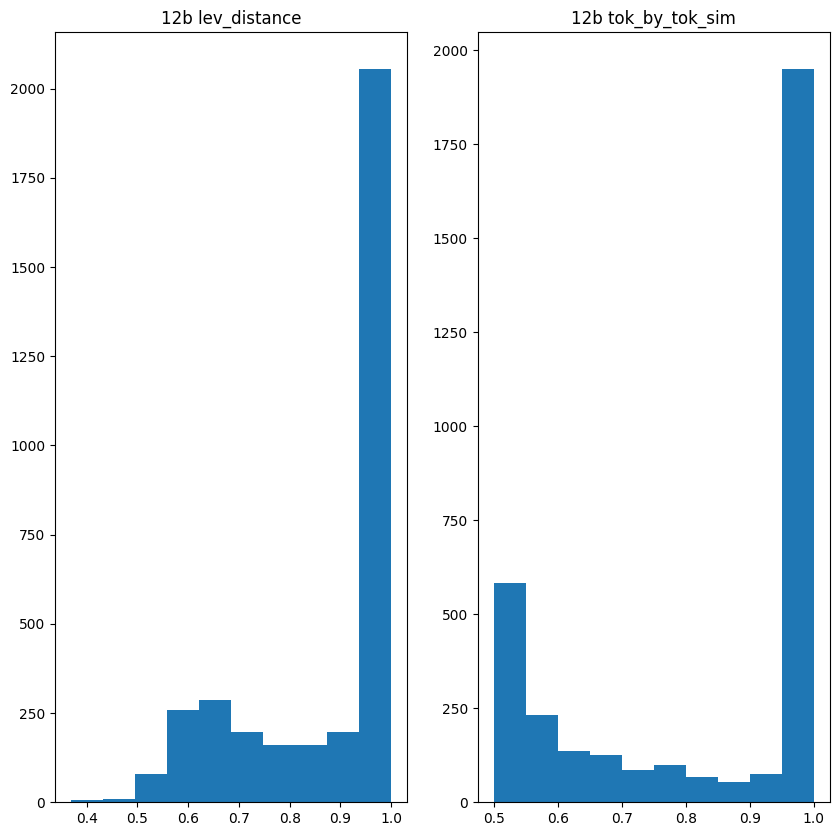

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].hist(df['lev_distance'])
ax[1].hist(df['tok_by_tok_sim'])
ax[0].set_title('12b lev_distance')
ax[1].set_title('12b tok_by_tok_sim')
plt.show()

In [52]:
neg = df[df['tok_by_tok_sim'] <= 0.55]
pos = df[df['tok_by_tok_sim'] == 1]

print(len(neg), len(pos))

min_len = min(len(neg), len(pos))

positive_idxs = pos.index.tolist()
negative_idxs = neg.index.tolist()

import numpy as np
np.random.seed(0)
positive_idxs = np.random.choice(positive_idxs, min_len, replace=False)
negative_idxs = np.random.choice(negative_idxs, min_len, replace=False)

final_tokens = []
final_str = []
labels = []
for i in tqdm(positive_idxs): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)
for i in tqdm(negative_idxs):
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(0)

print(len(final_tokens), len(final_str), len(labels), len(df))
print(sum(labels)/len(labels))

582 1788


100%|██████████| 582/582 [00:00<00:00, 97756.80it/s]

1164 1164 1164 3407
0.5


In [55]:
from datasets import Dataset, DatasetDict, load_from_disk
idxs = positive_idxs.tolist() + negative_idxs.tolist()
mem_dist_dataset = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': idxs})
print(len(mem_dist_dataset))

mem_dist_dataset

1164


Dataset({
    features: ['input_ids', 'text', 'labels', 'orig_idx'],
    num_rows: 1164
})

In [56]:
generalization_datasets = DatasetDict({'fuzzy_pos': fuzzy_pos, 'prefix': prefix_dataset, 'mem_dist': mem_dist_dataset})
generalization_datasets.save_to_disk(os.path.join(path, 'generalization_datasets'))
generalization_datasets

Saving the dataset (1/1 shards): 100%|██████████| 1164/1164 [00:00<00:00, 325499.69 examples/s]


DatasetDict({
    fuzzy_pos: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 205
    })
    prefix: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 8770
    })
    mem_dist: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 1164
    })
})